# Starbucks Capstone Challenge

## Project Overview
In this project, I will use dataset from Starbucks which simulates how people make purchasing decisions and how those behaviors are influenced by promotional offers.

People have hidden traits which could influence their purchasing patterns and associated with their observable traits. These traits can be observed in their interactions with Starbucks app.

The data sets used in this analysis are in the form of the following three files:
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed 

The schema and detailed explanation of each variable in the files will be explained along the analysis.


## Questions to Be Answer

In this analysis, I'm most interested in the following two questions: 
* Q1: Which offers are most effective?
* Q2: How can we split customers into different group? And how each group reacts to the offers?

For question one, I'll **compute the completion rates for each offer** to find the most effectice offer (That is , the offer with highest completion rate). And then, I would like to **run a simple decision tree model and visualize its spliting pattern** to get a sense of what factors might be important.


Next, for question two, I'll try to compute more features for the customer profile data, and run **clustering** on the data to see what kind of segmentation we get. And then we might be able to how each group respond to different offers (Again, completion rates or amount spent). 


## Data Exploration and Preprocessing
Explore and clean the three dataframe for data mining.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

import dateutil

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### 1. Portfolio Data
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
# Take a look
print("Portfolio: {} records".format(portfolio.shape[0]))
portfolio

Portfolio: 10 records


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


This dataset has only 10 records, corresponding to the 10 promotional offers.

##### Assess
* Every entry's channels column has multiple values. The column could be splitted by different media.  
* Offer ids should be renamed for this analysis

##### Clean
* Split the channels column
* Rename the offer ids

In [7]:
# Copy
portfolio_clean = portfolio.copy()

# All media types
media = ['web', 'email', 'mobile', 'social']

# Create columns for all media
for medium in media:
    portfolio_clean['ch_' + medium] = portfolio_clean['channels'].str.contains(medium, regex=False)

# Change column order
new_col_order = [
    'id', 'offer_type', 'difficulty', 'duration', 'reward',
    'ch_web', 'ch_email', 'ch_mobile', 'ch_social'
]
portfolio_clean = portfolio_clean[new_col_order]

# Rename ids
old_to_new_ids = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
    '3f207df678b143eea3cee63160fa8bed': 'info1',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
    'fafdcd668e3743c1bb461111dcafc2a4': 'discount3',
    '5a8bc65990b245e5a138643cd4eb9837': 'info2',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
    '2906b810c7d4411798c6938adc9daaa5': 'discount4'
}
portfolio_clean['id'] = portfolio_clean['id'].map(old_to_new_ids) 

# Final result
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False
3,bogo3,bogo,5,7,5,True,True,True,False
4,discount1,discount,20,10,5,True,True,False,False
5,discount2,discount,7,7,3,True,True,True,True
6,discount3,discount,10,10,2,True,True,True,True
7,info2,informational,0,3,0,False,True,True,True
8,bogo4,bogo,5,5,5,True,True,True,True
9,discount4,discount,10,7,2,True,True,True,False


##### Statistics

In [8]:
# Basic Stats
portfolio_clean.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [12]:
# Kurtosis
portfolio_clean[['difficulty', 'duration', 'reward']].kurtosis()

difficulty    1.347032
duration     -0.584304
reward       -0.455486
dtype: float64

#### 2. Profile Data
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [15]:
# Take a look
print("Profile: {} records".format(profile.shape[0]))
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

Profile: 17000 records


,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
# Data types
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null datetime64[ns]
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.1+ KB


In [17]:
# Missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [18]:
# What about age == 118
profile[profile['age']==118].sample(10)

,age,became_member_on,gender,id,income
16037,118,2016-06-05,None,17df9c48780d4124b2448aeedb3ba095,NaN
15638,118,2017-10-01,None,372fc13ae63745a3856111aea90114db,NaN
639,118,2016-08-24,None,fcaccfeda18b4ac08d5a25b64b4368f2,NaN
7906,118,2018-02-20,None,39145fee7c1240469a46bf939fb8370c,NaN
904,118,2016-03-06,None,c1da72caf3c34c359429b217456cf2eb,NaN
12805,118,2017-10-27,None,763c4dff89034d43a12a6181f1545c5e,NaN
15774,118,2017-07-08,None,fa75661c3aa848ea9090b77c9ecf37b6,NaN
14873,118,2018-03-29,None,fb17d322628a455493f942d1b8d6c808,NaN
13980,118,2017-12-30,None,a55e739b02374ac18ea0e8191b81bdce,NaN
11400,118,2018-03-03,None,f488a534b7204529908f1f95a6bd92cd,NaN


##### Assess
* About 2175 rows have missing data on gender and income, and their age are all 118.
* Person ids can be renamed

##### Clean
* Drop the 2175 abnormal rows
* Rename the person ids

In [19]:
# Copy the data
profile_clean = profile.copy()

# Rename Person Ids
# build a dict
person_id_map = {}
count = 1
for id_ in profile_clean.id.unique():
    person_id_map[id_] = 'person' + str(count)
    count = count+1
# rename
profile_clean['id'] = profile_clean['id'].map(person_id_map)

# Dropna
profile_clean = profile_clean.dropna()

# Resulting dataframe
profile_clean.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0
8,65,2018-02-09,M,person9,53000.0
12,58,2017-11-11,M,person13,51000.0


##### Statistics and Visualization

In [20]:
# Statistics after dropping nan
profile_clean.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


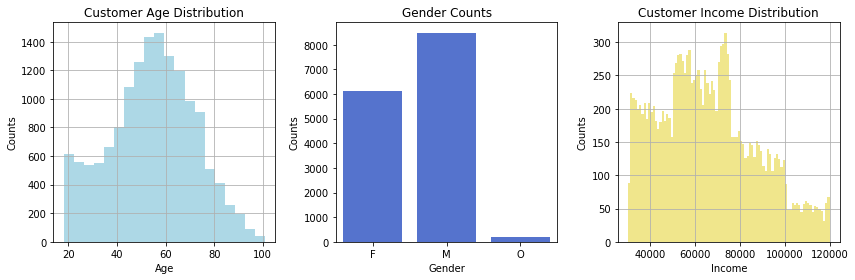

In [21]:
plt.figure(figsize=(12,4))

# Age distribution
plt.subplot(131)
profile_clean['age'].hist(bins=20, color='lightblue')
plt.title('Customer Age Distribution');
plt.ylabel('Counts');
plt.xlabel('Age');

# Genders
plt.subplot(132)
sns.countplot(profile_clean['gender'].fillna('Unknown'), color='royalblue');
plt.ylabel('Counts');
plt.xlabel('Gender');
plt.title('Gender Counts')

# Age distribution
plt.subplot(133)
profile_clean['income'].hist(bins=90, color='khaki')
plt.title('Customer Income Distribution');
plt.ylabel('Counts');
plt.xlabel('Income');

plt.tight_layout()

In [25]:
# Skewness
profile_clean.skew()

age      -0.080766
income    0.402005
dtype: float64

In [24]:
# Kurtosis
profile_clean.kurtosis()

age      -0.502684
income   -0.558372
dtype: float64

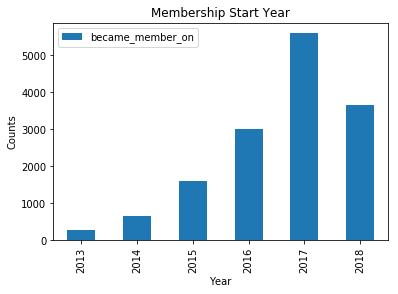

In [12]:
# https://stackoverflow.com/questions/27365467/can-pandas-plot-a-histogram-of-dates
# Membership start time
profile_clean[['became_member_on']].groupby([profile.became_member_on.dt.year]).count().plot.bar(width=0.5);
plt.title('Membership Start Year');
plt.ylabel('Counts');
plt.xlabel('Year');

#### 3. Transcript Data
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [13]:
# Take a look
print("Transcript: {} records".format(transcript.shape[0]))
transcript.head()

Transcript: 306534 records


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
# Data types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
# Statistics
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [16]:
# event types
transcript.event.unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [17]:
# number of person recevied
print('Number of unique customer: {}'.format(transcript.person.nunique()))

Number of unique customer: 17000


In [18]:
# average offer received per person
print('Average offers received by a person: {}'.format(np.round(transcript.shape[0]/transcript.person.nunique(),0)))

Average offers received by a person: 18.0


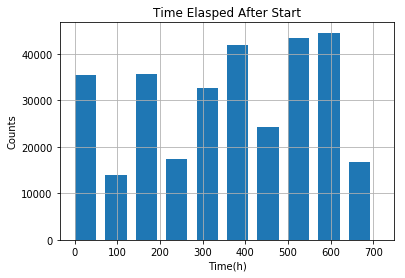

In [19]:
# Test time elapsed
transcript.time.hist(width=50);
plt.title('Time Elasped After Start');
plt.ylabel('Counts');
plt.xlabel('Time(h)');

In [20]:
# Event and actions
for event in transcript.event.unique().tolist():
    print('*** Event: {} ***'.format(event))
    print(transcript[transcript['event']==event][['event','value']].head(3))
    print()

*** Event: offer received ***
            event                                             value
0  offer received  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1  offer received  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2  offer received  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}

*** Event: offer viewed ***
              event                                             value
12650  offer viewed  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651  offer viewed  {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652  offer viewed  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}

*** Event: transaction ***
             event                           value
12654  transaction  {'amount': 0.8300000000000001}
12657  transaction               {'amount': 34.56}
12659  transaction               {'amount': 13.23}

*** Event: offer completed ***
                 event                                              value
12658  offer completed  {'offer_id': '2906b810c7d44

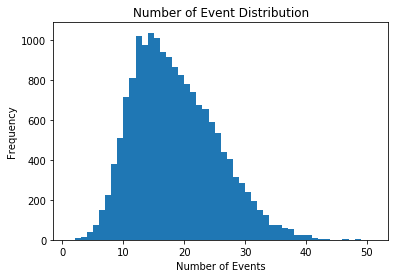

In [21]:
# Total event number for each person
transcript.groupby('person').size().plot.hist(bins=50)
plt.title('Number of Event Distribution');
plt.ylabel('Frequency');
plt.xlabel('Number of Events');

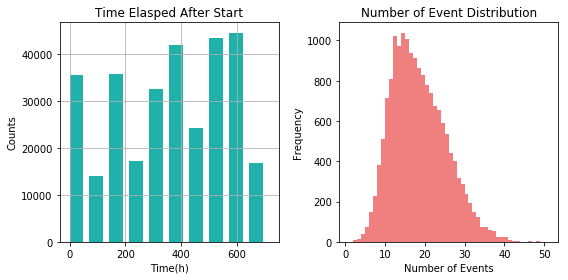

In [31]:
# Combine the above two pltos together
plt.figure(figsize=(8,4))

# Age distribution
plt.subplot(121)
transcript.time.hist(width=50, color='lightseagreen');
plt.title('Time Elasped After Start');
plt.ylabel('Counts');
plt.xlabel('Time(h)');

# Genders
plt.subplot(122)
transcript.groupby('person').size().plot.hist(bins=50, color='lightcoral')
plt.title('Number of Event Distribution');
plt.ylabel('Frequency');
plt.xlabel('Number of Events');

plt.tight_layout()

In [22]:
# Take a look on the events of single customer
transcript[transcript['person'] == transcript.person.sample().values[0]]

,event,person,time,value
1984,offer received,c8b16cc25eed4d27b5da91976b105a32,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
15958,offer viewed,c8b16cc25eed4d27b5da91976b105a32,6,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
49666,transaction,c8b16cc25eed4d27b5da91976b105a32,144,{'amount': 27.37}
51497,transaction,c8b16cc25eed4d27b5da91976b105a32,156,{'amount': 16.8}
152595,offer received,c8b16cc25eed4d27b5da91976b105a32,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
174797,transaction,c8b16cc25eed4d27b5da91976b105a32,426,{'amount': 39.33}
174798,offer completed,c8b16cc25eed4d27b5da91976b105a32,426,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
182925,transaction,c8b16cc25eed4d27b5da91976b105a32,444,{'amount': 18.25}
203544,offer received,c8b16cc25eed4d27b5da91976b105a32,504,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
303412,transaction,c8b16cc25eed4d27b5da91976b105a32,702,{'amount': 22.79}


In [23]:
transcript['person'].nunique()

17000

##### Assess
* In the value columns, offer id key has different forms: 'offer_id' and 'offer id'. This should be unified. 
* For the ease of processing, I'd like to split the dataframe into two: Offer related and transaction only
* `offer_id` values should be renamed based on previous section
* `person` id should be renamed based on previous section

##### Clean

* Split the `transcript` into `transaction_clean` and `offer_reaction_clean` 
* Rename `offer_id` values
* Rename `person` values

In [24]:
# Extract transaction only data
transaction_clean = transcript[transcript['event'] == 'transaction'].copy()
transaction_clean['amount'] = transaction_clean['value'].apply(lambda x: x['amount'])
transaction_clean = transaction_clean.drop(['event', 'value'], axis=1)

# Rename person
transaction_clean['person'] = transaction_clean['person'].map(person_id_map)

# Resulting dataframe
transaction_clean.head()

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23
12670,person135,0,19.51
12671,person152,0,18.97


In [25]:
# Extract offer related data
offer_reaction_clean = transcript[transcript['event'] != 'transaction'].copy()
offer_reaction_clean['offer_id'] = offer_reaction_clean['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else x['offer id'])
offer_reaction_clean = offer_reaction_clean.drop(['value'], axis=1)

# Rename offer ids
offer_reaction_clean['offer_id'] = offer_reaction_clean['offer_id'].map(old_to_new_ids)

# Rename person
offer_reaction_clean['person'] = offer_reaction_clean['person'].map(person_id_map)

# Resulting dataframe
offer_reaction_clean.head()

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4
3,offer received,person7,0,discount3
4,offer received,person8,0,bogo2


## Clean Data
Now that we have rather clean data, we can start the analysis.  
Here is a summary for the clean data:

#### portfolio_clean
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* ch_web (bool) - Web channel
* ch_email (bool) - Email channel
* ch_mobile (bool) - Mobile channel
* ch_social (bool) - Social channel

#### profile_clean
* age (int) - age of the customer 
* became_member_on (datetime64) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

#### transaction_clean
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* amount (float) - amount spent in the transaction

#### offer_reaction_clean
* event (str) - record description (offer received/offer viewed/offer completed)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* offer_id - (str) - offer id

In [26]:
portfolio_clean.head(3)

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False


In [27]:
profile_clean.head(3)

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0


In [28]:
transaction_clean.head(3)

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23


In [29]:
offer_reaction_clean.head(3)

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4


## Data Mining

In the following sections, I will perform further exploration or modeling on the clean dataset to answer the two questions listed in the early section.  
The exploration of the answers to each question will follow the CRISP-DM(Cross-Industry Standard Process for Data Mining) process.


### Q1: Which offers are most effective?
#### 1. Business Understaning
From an enterprise's point of view, evaluating and assessing marketing/promotion results is critical.  
These assessment can be made through simple summary of target metric of different features.  For more advanced analysis, statistical model such as decision tree might be helpful.

##### Target Metric
* Offer completion rate

##### Features
* Offer type
* Duration/difficulty/reward
* Channel
* Other computed features


#### 2. Data Understaning
I'll use only `portfolio_clean` and `offer_reaction_clean` in these section.  Let's explore the data further.

In [30]:
# Portfolio
portfolio_clean

,id,offer_type,difficulty,duration,reward,ch_web,ch_email,ch_mobile,ch_social
0,bogo1,bogo,10,7,10,False,True,True,True
1,bogo2,bogo,10,5,10,True,True,True,True
2,info1,informational,0,4,0,True,True,True,False
3,bogo3,bogo,5,7,5,True,True,True,False
4,discount1,discount,20,10,5,True,True,False,False
5,discount2,discount,7,7,3,True,True,True,True
6,discount3,discount,10,10,2,True,True,True,True
7,info2,informational,0,3,0,False,True,True,True
8,bogo4,bogo,5,5,5,True,True,True,True
9,discount4,discount,10,7,2,True,True,True,False


In [31]:
# Offer Reaction
print("Offer Reaction: {} records".format(offer_reaction_clean.shape[0]))
offer_reaction_clean[['event', 'offer_id']].sample(5)

Offer Reaction: 167581 records


,event,offer_id
12071,offer received,bogo4
102710,offer completed,bogo3
9237,offer received,info1
222854,offer completed,discount3
19162,offer completed,discount2


**Observation**  

`portfolio_clean` is lack of target metric (completion rate), which can be calculated using `offer_reaction_clean`.  
Besides target metric, some auxiliary features(view rates, etc) can also be computed from `offer_reaction_clean` data.

#### 3. Data Preparation


In [32]:
# Make a copy
df_Q1 = portfolio_clean.copy()

# Features to used in this section
df_Q1[['id', 'offer_type', 'difficulty', 'reward']]

,id,offer_type,difficulty,reward
0,bogo1,bogo,10,10
1,bogo2,bogo,10,10
2,info1,informational,0,0
3,bogo3,bogo,5,5
4,discount1,discount,20,5
5,discount2,discount,7,3
6,discount3,discount,10,2
7,info2,informational,0,0
8,bogo4,bogo,5,5
9,discount4,discount,10,2


In [33]:
# Compute offer statistics
offer_statistics = []
for offer_id in offer_reaction_clean['offer_id'].unique():
    offer_stat = offer_reaction_clean[offer_reaction_clean['offer_id'] == offer_id].groupby('event').size().to_dict()
    offer_stat['id'] = offer_id
    offer_statistics.append(offer_stat)

# Transform the statistics into Dataframe
df_offer_stat = pd.DataFrame(offer_statistics)[['id', 'offer received', 'offer viewed', 'offer completed']]

# Compute the rate
df_offer_stat['offer_complete_rate'] = df_offer_stat['offer completed'] / df_offer_stat['offer received']
df_offer_stat['offer_view_rate'] = df_offer_stat['offer viewed'] / df_offer_stat['offer received']

# Keep the columns interested
#df_offer_stat = df_offer_stat[['id', 'offer_view_rate', 'offer_complete_rate']]
df_offer_stat

,id,offer received,offer viewed,offer completed,offer_complete_rate,offer_view_rate
0,bogo3,7677,4171,4354.0,0.567149,0.543311
1,discount1,7668,2663,3420.0,0.446009,0.347287
2,discount4,7632,4118,4017.0,0.526336,0.539570
3,discount3,7597,7327,5317.0,0.699882,0.964460
4,bogo2,7593,7298,3331.0,0.438694,0.961148
5,bogo4,7571,7264,4296.0,0.567428,0.959451
6,discount2,7646,7337,5156.0,0.674340,0.959587
7,info1,7617,4144,NaN,NaN,0.544046
8,bogo1,7658,6716,3688.0,0.481588,0.876991
9,info2,7618,6687,NaN,NaN,0.877789


In [34]:
# Join the dataset
df_Q1 = df_Q1.join(df_offer_stat.set_index('id'), on='id').drop(['offer received', 'offer viewed', 'offer completed'], axis=1)
df_Q1 = df_Q1[['id', 'offer_type', 'difficulty', 'duration', 'reward', 'offer_complete_rate', 'offer_view_rate']]

In [35]:
df_Q1

,id,offer_type,difficulty,duration,reward,offer_complete_rate,offer_view_rate
0,bogo1,bogo,10,7,10,0.481588,0.876991
1,bogo2,bogo,10,5,10,0.438694,0.961148
2,info1,informational,0,4,0,NaN,0.544046
3,bogo3,bogo,5,7,5,0.567149,0.543311
4,discount1,discount,20,10,5,0.446009,0.347287
5,discount2,discount,7,7,3,0.674340,0.959587
6,discount3,discount,10,10,2,0.699882,0.964460
7,info2,informational,0,3,0,NaN,0.877789
8,bogo4,bogo,5,5,5,0.567428,0.959451
9,discount4,discount,10,7,2,0.526336,0.539570


#### 4. Results evaluation
##### (1) Offer Complete Rate by Offer Type

In [36]:
# Since informational offer has not complete status, I'll drop those records
df_Q1_comp = df_Q1[['id', 'offer_type', 'offer_complete_rate']].sort_values(by='offer_complete_rate', ascending=False).dropna()
df_Q1_comp

,id,offer_type,offer_complete_rate
6,discount3,discount,0.699882
5,discount2,discount,0.674340
8,bogo4,bogo,0.567428
3,bogo3,bogo,0.567149
9,discount4,discount,0.526336
0,bogo1,bogo,0.481588
4,discount1,discount,0.446009
1,bogo2,bogo,0.438694


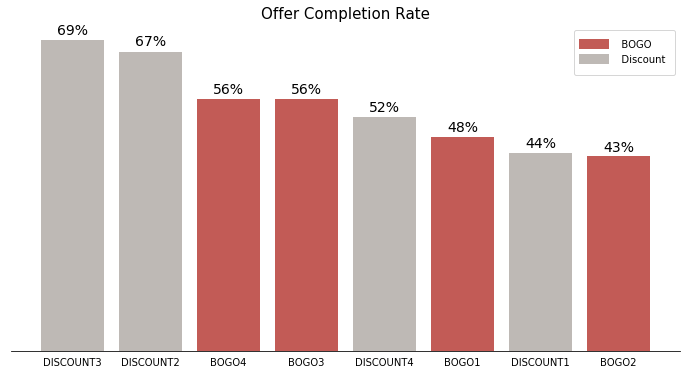

In [37]:
# Color map for bogo and discount
# https://www.colorcombos.com/
cate_colors = df_Q1_comp.offer_type.map({'bogo': '#c25b56', 'discount': '#beb9b5'})

# Percentage
df_Q1_comp['offer_complete_rate_per'] = df_Q1_comp['offer_complete_rate'].apply(lambda x: np.round(x*100, 2))

# Plottling
fig, ax = plt.subplots(figsize=(12,6))
bar_rect = ax.bar(x=df_Q1_comp['id'].str.upper(), height=df_Q1_comp['offer_complete_rate_per'], color=cate_colors)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Legned for color ref: https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
custom_lines = [Line2D([0], [0], color='#c25b56', lw=10),
                Line2D([0], [0], color='#beb9b5', lw=10)]
ax.legend(custom_lines, ['   BOGO', '   Discount'], borderpad=1);

# Hide x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Autolabel Function
# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
def autolabel(rects, unit=''):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0: continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height) + unit,
                ha='center', va='bottom', fontsize=14)

# Label the percentage on top of bars
autolabel(bar_rect, '%')
plt.title('Offer Completion Rate', size=15);

In [38]:
# Avergage completion rate by type
df_Q1_comp.groupby(['offer_type']).mean()[['offer_complete_rate']]

,offer_complete_rate
offer_type,
bogo,0.513715
discount,0.586642


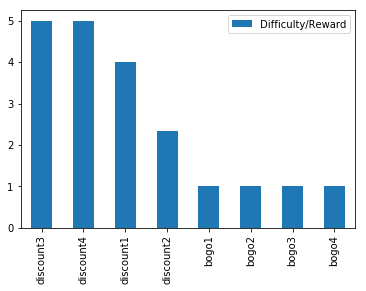

In [39]:
# Difficulty over reward
df_Q1['Difficulty/Reward'] = df_Q1['difficulty'] / df_Q1['reward']
df_Q1.sort_values(by='Difficulty/Reward', ascending=False).dropna().plot.bar(x='id', y='Difficulty/Reward');
plt.xlabel('');

##### Observation
* The two highest completion rates come from discount offers.
* Discount offer also has higher completion rate in average.
* The higher the difficulty/reward ratio, the higher the profit. `Discount3` is most effective since it has the highest completion rate and difficulty/reward ratio.

##### (2) Offer View Rate by Offer Type

In [40]:
# Data for view rate
df_Q1_view= df_Q1[['id', 'offer_type', 'offer_view_rate']].sort_values(by='offer_view_rate', ascending=False)
df_Q1_view

,id,offer_type,offer_view_rate
6,discount3,discount,0.964460
1,bogo2,bogo,0.961148
5,discount2,discount,0.959587
8,bogo4,bogo,0.959451
7,info2,informational,0.877789
0,bogo1,bogo,0.876991
2,info1,informational,0.544046
3,bogo3,bogo,0.543311
9,discount4,discount,0.539570
4,discount1,discount,0.347287


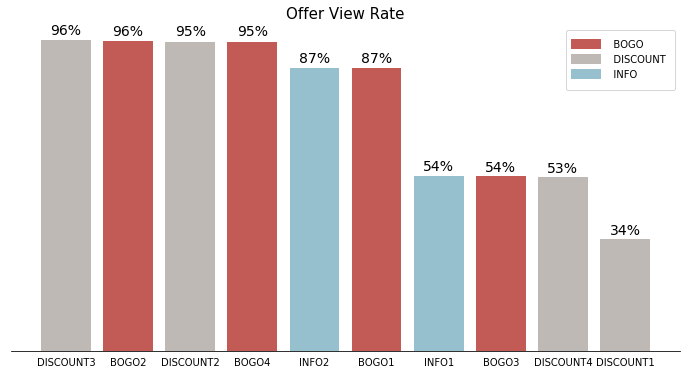

In [41]:
# Color map for bogo and discount
# https://www.colorcombos.com/
cate_colors = df_Q1_view.offer_type.map({'bogo': '#c25b56', 'discount': '#beb9b5', 'informational': '#96c0ce'})

# Percentage
df_Q1_view['offer_view_rate_per'] = df_Q1_view['offer_view_rate'].apply(lambda x: np.round(x*100, 2))

# Plottling
fig, ax = plt.subplots(figsize=(12,6))
bar_rect = ax.bar(x=df_Q1_view['id'].str.upper(), height=df_Q1_view['offer_view_rate_per'], color=cate_colors)
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Legned for color ref: https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
custom_lines = [Line2D([0], [0], color='#c25b56', lw=10),
                Line2D([0], [0], color='#beb9b5', lw=10),
                Line2D([0], [0], color='#96c0ce', lw=10)]
ax.legend(custom_lines, ['   BOGO', '   DISCOUNT', '   INFO'], borderpad=1);

# Hide x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Autolabel Function
# https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
def autolabel(rects, unit=''):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height == 0: continue
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height) + unit,
                ha='center', va='bottom', fontsize=14)

# Label the percentage on top of bars
autolabel(bar_rect, '%')
plt.title('Offer View Rate', size=15);

In [42]:
# Avergage view rate by type
df_Q1_view.groupby(['offer_type']).mean()[['offer_view_rate']]

,offer_view_rate
offer_type,
bogo,0.835225
discount,0.702726
informational,0.710918


##### Observation
* BOGO offer has higher view rate in average.
* BOGO2 has very high view rate but low completion rate.

##### (3) Offer Complete Rate correlation with other numerical parameters

In [43]:
# Correlation
q1_corr = df_Q1[['difficulty', 'duration', 'reward', 'offer_view_rate', 'offer_complete_rate']].corr()
q1_corr

,difficulty,duration,reward,offer_view_rate,offer_complete_rate
difficulty,1.000000,0.808414,0.465686,-0.300024,-0.487553
duration,0.808414,1.000000,0.160262,-0.255880,0.248762
reward,0.465686,0.160262,1.000000,0.224391,-0.697518
offer_view_rate,-0.300024,-0.255880,0.224391,1.000000,0.424601
offer_complete_rate,-0.487553,0.248762,-0.697518,0.424601,1.000000


In [44]:
# Corr Ploting
# https://stackoverflow.com/questions/39409866/correlation-heatmap
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

q1_corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_precision(2)

,difficulty,duration,reward,offer_view_rate,offer_complete_rate
difficulty,1,0.81,0.47,-0.3,-0.49
duration,0.81,1,0.16,-0.26,0.25
reward,0.47,0.16,1,0.22,-0.7
offer_view_rate,-0.3,-0.26,0.22,1,0.42
offer_complete_rate,-0.49,0.25,-0.7,0.42,1


##### Observation
* Offer complete rate has moderate positive correlation with offer view rate, and weak positive correlation with offer duration .
* Offer complete rate has moderate negative relationship with difficulty and reward.
* Note that there are some colinearities exist in the parameters(such as difficulty and reward).
* Note that the data might be not enough to conclude the relationship.

### Q2: How can we split customers into different group? And how each group reacts to the offers?

#### 1. Business Understaning
We now know some general properties of various offers.  
But what we really care is how customers differ, because different types of offers might attract different type of customers

So in this section I'll run **clustering** on the profile data to see what kind of customer segmentation we get. And then we might be able to assess how each group respond to different offers (Again, completion rates or amount spent). 


#### 2. Data Understaning
I'll use only `profile_clean`, `transaction_clean`, and `offer_reaction_clean` in these section. 

In [45]:
# Profile: age, became_member_on, gender, income: 4 attributes
profile_clean.head(3)

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,person2,112000.0
3,75,2017-05-09,F,person4,100000.0
5,68,2018-04-26,M,person6,70000.0


In [46]:
# Transaction: Spending
transaction_clean.head(3)

,person,time,amount
12654,person42,0,0.83
12657,person56,0,34.56
12659,person64,0,13.23


In [47]:
# Offer reaction: view rate, complete rate, etc
offer_reaction_clean.head(3)

,event,person,time,offer_id
0,offer received,person4,0,bogo3
1,offer received,person5,0,discount1
2,offer received,person6,0,discount4


#### 3. Data Preparation
To perform clustering, I'd like to extract features from `transaction_clean` and `offer_reaction_clean` dataframe, and add the derived features to `profile_clean`

In [48]:
# Utility function for printing out dictionary content
def printDictUpToNPairs(d, n):
    """ Print key-value pairs of given dictionary up to nth pair
    
    Args:
        d: Dictionray to be print
        n: Upper limit of the number of key-values printed
    Returns:
        None
    
    """
    if type(d) != dict:
        print('Argument d is not a dictionary')
        return
    
    for i, key in enumerate(d):
        if i >= n:
            break
        else:
            print('{} : {}'.format(key, d[key]))

In [49]:
# Obtain additional spending data from transaction_clean
spending_dict = transaction_clean.groupby(['person'])['amount'].sum().to_dict()
# Print the first five key-value pairs
printDictUpToNPairs(spending_dict, 5)   

person1 : 20.4
person10 : 15.620000000000001
person100 : 34.04
person1000 : 19.78
person10000 : 7.279999999999999


In [ ]:
# Obtain offer view and complete metric from offer_reaction_clean dataframe

# BOGO and DISCOUNT ids
bogo_ids = portfolio_clean[portfolio_clean.id.str.contains('bogo')].id.values
discount_ids = portfolio_clean[portfolio_clean.id.str.contains('discount')].id.values

# Compute person statistics
person_statistics = []
for person in offer_reaction_clean['person'].unique():
    # BOGO
    offer_bogo = offer_reaction_clean[offer_reaction_clean.offer_id.isin(bogo_ids)]
    offer_bogo = offer_bogo[offer_bogo['person'] == person].groupby('event').size()
    offer_bogo = offer_bogo.rename({'offer received': 'bogo offer received', 'offer viewed': 'bogo offer viewed', 'offer completed': 'bogo offer completed'})
    # DISCOUNT
    offer_discount = offer_reaction_clean[offer_reaction_clean.offer_id.isin(discount_ids)]
    offer_discount = offer_discount[offer_discount['person'] == person].groupby('event').size()
    offer_discount = offer_discount.rename({'offer received': 'discount offer received', 'offer viewed': 'discount offer viewed', 'offer completed': 'discount offer completed'})
    # Combine
    person_stat = offer_bogo.to_dict()
    person_stat.update(offer_discount.to_dict())
    person_stat['person'] = person
    person_statistics.append(person_stat)

# Dataframe, to pickle
fina_cols = ['person', 'bogo offer received', 'bogo offer viewed', 'bogo offer completed', 'discount offer received', 'discount offer viewed', 'discount offer completed']
df_person_stat = pd.DataFrame(person_statistics)[fina_cols].fillna(0)
df_person_stat.to_pickle("./df_person_stat.pkl")

In [50]:
# Unpickle the dataframe
unpickled_df_person_stat = pd.read_pickle("./df_person_stat.pkl")
unpickled_df_person_stat.head()

,person,bogo offer received,bogo offer viewed,bogo offer completed,discount offer received,discount offer viewed,discount offer completed
0,person4,3.0,3.0,3.0,0.0,0.0,0.0
1,person5,0.0,0.0,0.0,3.0,2.0,0.0
2,person6,1.0,1.0,1.0,2.0,2.0,1.0
3,person7,1.0,1.0,0.0,3.0,3.0,0.0
4,person8,3.0,2.0,0.0,2.0,2.0,0.0


In [51]:
# Compute the offer view rates and complete rates
unpickled_df_person_stat['bogo_offer_view_rate'] = unpickled_df_person_stat['bogo offer viewed'] / unpickled_df_person_stat['bogo offer received']
unpickled_df_person_stat['bogo_offer_complete_rate'] = unpickled_df_person_stat['bogo offer completed'] / unpickled_df_person_stat['bogo offer received']
unpickled_df_person_stat['discount_offer_view_rate'] = unpickled_df_person_stat['discount offer viewed'] / unpickled_df_person_stat['discount offer received']
unpickled_df_person_stat['discount_offer_complete_rate'] = unpickled_df_person_stat['discount offer completed'] / unpickled_df_person_stat['discount offer received']
unpickled_df_person_stat = unpickled_df_person_stat[['person', 'bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate']]
unpickled_df_person_stat.head(3)

,person,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate
0,person4,1.0,1.0,NaN,NaN
1,person5,NaN,NaN,0.666667,0.0
2,person6,1.0,1.0,1.000000,0.5


In [52]:
# Create dataframe for later clustering task
df_Q2 = profile_clean.join(unpickled_df_person_stat.set_index('person'), on='id') # Append view/complete rate
df_Q2['spending'] = df_Q2['id'].map(spending_dict).fillna(0) # Add spending
#df_Q2['became_member_on'] = df_Q2['became_member_on'].dt.strftime('%Y') # Extract only year
df_Q2 = df_Q2.drop(['id'], axis=1)

# Take a look
df_Q2.head(3)

,age,became_member_on,gender,income,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate,spending
1,55,2017-07-15,F,112000.0,0.0,1.0,NaN,NaN,77.01
3,75,2017-05-09,F,100000.0,1.0,1.0,NaN,NaN,159.27
5,68,2018-04-26,M,70000.0,1.0,1.0,1.0,0.5,57.73


In [53]:
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 9 columns):
age                             14825 non-null int64
became_member_on                14825 non-null datetime64[ns]
gender                          14825 non-null object
income                          14825 non-null float64
bogo_offer_view_rate            13082 non-null float64
bogo_offer_complete_rate        13082 non-null float64
discount_offer_view_rate        13042 non-null float64
discount_offer_complete_rate    13042 non-null float64
spending                        14825 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 1.8+ MB


#### 4. Data Modeling

To perform clustering on the dataset, the following steps should be carried out:  
* Compute `membership_duration` from `became_member_on` column
* One-hot encode `gender` column
* Standard-scale all columns
* Perform PCA(Principal Component Analysis)
* Perform K-Mean Clustering

##### Membership Duration

In [54]:
# latest membership date
print(df_Q2.became_member_on.max())

2018-07-26 00:00:00


In [55]:
# newest member list
newest_members = profile_clean[profile_clean.became_member_on == profile_clean.became_member_on.max()].id

# Hours after last membership date
hours_aft = transaction_clean[transaction_clean.person.isin(newest_members)].time.max()

# last transaction time: days after 2018-7-26
last_trans_time = df_Q2.became_member_on.max() + dateutil.relativedelta.relativedelta(hours=float(hours_aft))
print(last_trans_time)

2018-08-24 12:00:00


In [56]:
# Extract membership duration and drop became_member_on
df_Q2['membership_duration'] = df_Q2['became_member_on'].apply(lambda x: (last_trans_time - x).days)
df_Q2 = df_Q2.drop(['became_member_on'], axis=1)
df_Q2[['age', 'gender', 'income', 'membership_duration', 'spending', 'bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate']].head(3)

,age,gender,income,membership_duration,spending,bogo_offer_view_rate,bogo_offer_complete_rate,discount_offer_view_rate,discount_offer_complete_rate
1,55,F,112000.0,405,77.01,0.0,1.0,NaN,NaN
3,75,F,100000.0,472,159.27,1.0,1.0,NaN,NaN
5,68,M,70000.0,120,57.73,1.0,1.0,1.0,0.5


In [57]:
# Dataframe for clustering analysis
df_Q2_cluster = df_Q2.drop(['bogo_offer_view_rate', 'bogo_offer_complete_rate', 'discount_offer_view_rate', 'discount_offer_complete_rate', 'spending'], axis=1).copy()

##### One-hot Encoding

In [58]:
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
def one_hot(df, cols):
    """ One-hot encoding function
    
    Args:
        df: DataFrame
        cols: a list of columns to encode 
    Returns:
        a DataFrame with one-hot encoding
        
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([each], axis=1)
    return df

In [59]:
# One-hot encode two categorical columns
df_Q2_cluster = one_hot(df_Q2_cluster, ['gender'])
df_Q2_cluster.head(3)

,age,income,membership_duration,gender_F,gender_M,gender_O
1,55,112000.0,405,1,0,0
3,75,100000.0,472,1,0,0
5,68,70000.0,120,0,1,0


##### Standard Scaling
Prior to scaling, all the data types should be converted to float

In [60]:
# data types
df_Q2_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
age                    14825 non-null int64
income                 14825 non-null float64
membership_duration    14825 non-null int64
gender_F               14825 non-null uint8
gender_M               14825 non-null uint8
gender_O               14825 non-null uint8
dtypes: float64(1), int64(2), uint8(3)
memory usage: 506.7 KB


In [61]:
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
# Convert data types from int64/uint8 to float64
columnsToEncode = list(df_Q2_cluster.select_dtypes(include=['int64','uint8']))
for col in columnsToEncode:
    df_Q2_cluster[col] = df_Q2_cluster[col].astype(np.float64)

In [62]:
# Apply feature scaling to the df_Q2
scaler = StandardScaler()
for col in df_Q2_cluster.columns:
    df_Q2_cluster[col] = scaler.fit_transform(df_Q2_cluster[col].values.reshape(-1, 1))

# The resulting data
df_Q2_cluster.head(3)

,age,income,membership_duration,gender_F,gender_M,gender_O
1,0.034889,2.157419,-0.349433,1.191146,-1.156702,-0.120448
3,1.185430,1.601801,-0.189601,1.191146,-1.156702,-0.120448
5,0.782741,0.212756,-1.029314,-0.839528,0.864527,-0.120448


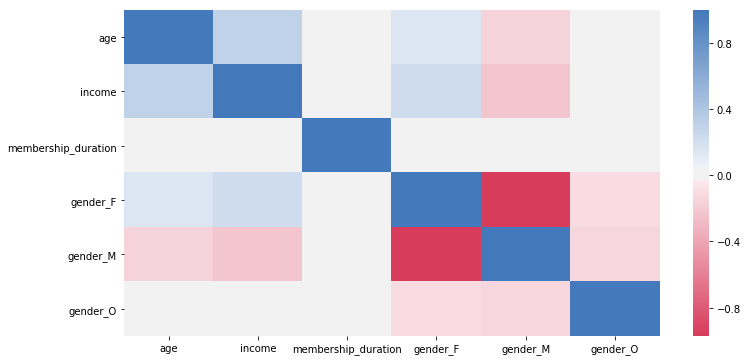

In [63]:
# Correlation Heatmap
plt.subplots(figsize=(12,6))
sns.heatmap(df_Q2_cluster.corr(), cmap=cmap)

After one-hot encoding, there seems to have some correlation between features, especially for gender and became_member_on derived features.

##### PCA
To find the optimal number of component to decompose, I'll first apply PCA without specifying the number of components and get the scree plot first to how much to keep.

In [64]:
# All components
pca = PCA()
df_Q2_pca = pca.fit(df_Q2_cluster)

# Feature conversion matrix
dimensions = ['Dimension {}'.format(i) for i in range(1, len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns = df_Q2_cluster.keys())
components.index = dimensions

# Proportion of explained variance of new components
ratios = df_Q2_pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

# PCA result: Feature conversion matrix + Explained variance
pca_result = pd.concat([variance_ratios, components], axis=1)
pca_result.head()

,Explained Variance,age,income,membership_duration,gender_F,gender_M,gender_O
Dimension 1,0.3578,0.2569,0.3235,-0.0124,0.6430,-0.6445,0.0184
Dimension 2,0.1915,-0.6578,-0.5789,-0.2386,0.2532,-0.2910,0.1624
Dimension 3,0.1711,0.1560,0.0853,-0.1205,-0.1829,-0.0479,0.9582
Dimension 4,0.1651,-0.1681,-0.0980,0.9627,0.0458,-0.0844,0.1617
Dimension 5,0.1145,0.6699,-0.7371,0.0400,0.0562,-0.0487,-0.0301


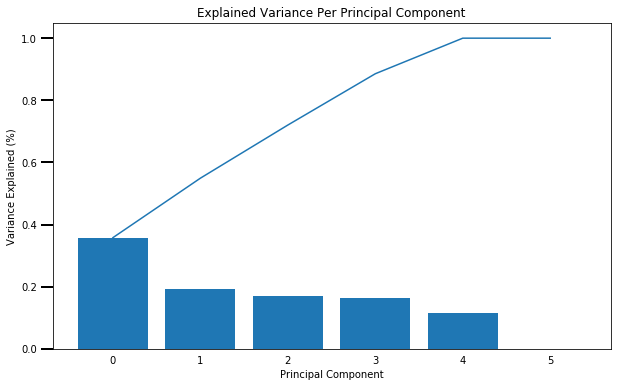

In [65]:
# Scree plot
num_components = len(df_Q2_pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = df_Q2_pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title("Explained Variance Per Principal Component")

In [66]:
# Number of component to keep
n_keep = np.argwhere(cumvals>0.95)[0][0] + 1
print('Retained 95% variance if keeping more than {} components'.format(n_keep))

Retained 95% variance if keeping more than 5 components


In [67]:
# Re-apply PCA to the data while selecting for number of components to retain.

# n_keep components
pca = PCA(n_components=n_keep, random_state=10)
df_Q2_pca = pca.fit_transform(df_Q2_cluster)

#### K-Mean clustering
For finding appropriate number of centers, sum of squared errors of points to closest cluster center is used.  The smaller the sum, the closer the points to their centroids.
Because the sum of squared errors will become smaller when we increase the number of centers, elbow method is used to find the optimal number of clusters.

Note: Another approach for determining the optimal number of cluster centers will be `Silhouette Analysis`

In [74]:
def kmean_distance(data, n_centers):
    # Fit the data
    kmeans = KMeans(n_clusters=n_centers, random_state=10).fit(data)
    # Return sume of distances (negative score)
    return kmeans.inertia_

In [75]:
# Over a number of different cluster counts...
centers = [2, 5, 8, 11, 14, 17, 20]
sses = []
#sih_scores= []
for n in centers:
    # run k-means clustering on the data
    # compute the average within-cluster distances.
    sses.append(kmean_distance(df_Q2_pca, n))
    #sih_scores.append(kmean_silhouette_score(df_Q2_pca, n))

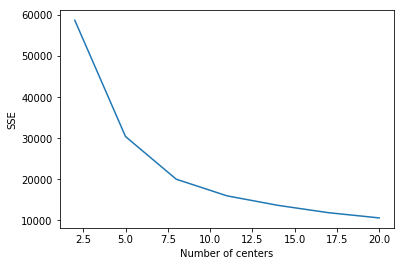

In [73]:
#Investigate the change in within-cluster distance across number of clusters.
# Plot the SSE (sum of square errors) versus number of centers
plt.plot(centers, sses)
plt.xlabel('Number of centers')
plt.ylabel('SSE')
plt.show()

The elbow occurs around 8-10 clusters. To simplify the analysis, I'll use 8 clusters here.

In [74]:
# Segrementation
n_clusters = 8
model = KMeans(n_clusters=n_clusters, random_state=10).fit(df_Q2_pca)
cluster_pred = model.predict(df_Q2_pca)

#### 5. Results evaluation

In [75]:
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 9 columns):
age                             14825 non-null int64
gender                          14825 non-null object
income                          14825 non-null float64
bogo_offer_view_rate            13082 non-null float64
bogo_offer_complete_rate        13082 non-null float64
discount_offer_view_rate        13042 non-null float64
discount_offer_complete_rate    13042 non-null float64
spending                        14825 non-null float64
membership_duration             14825 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.8+ MB


In [76]:
# Divide the dataset according the clustering results
clusters = []
for i in range(n_clusters):
    clusters.append(df_Q2[cluster_pred==i])

In [77]:
df_Q2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 9 columns):
age                             14825 non-null int64
gender                          14825 non-null object
income                          14825 non-null float64
bogo_offer_view_rate            13082 non-null float64
bogo_offer_complete_rate        13082 non-null float64
discount_offer_view_rate        13042 non-null float64
discount_offer_complete_rate    13042 non-null float64
spending                        14825 non-null float64
membership_duration             14825 non-null int64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.8+ MB


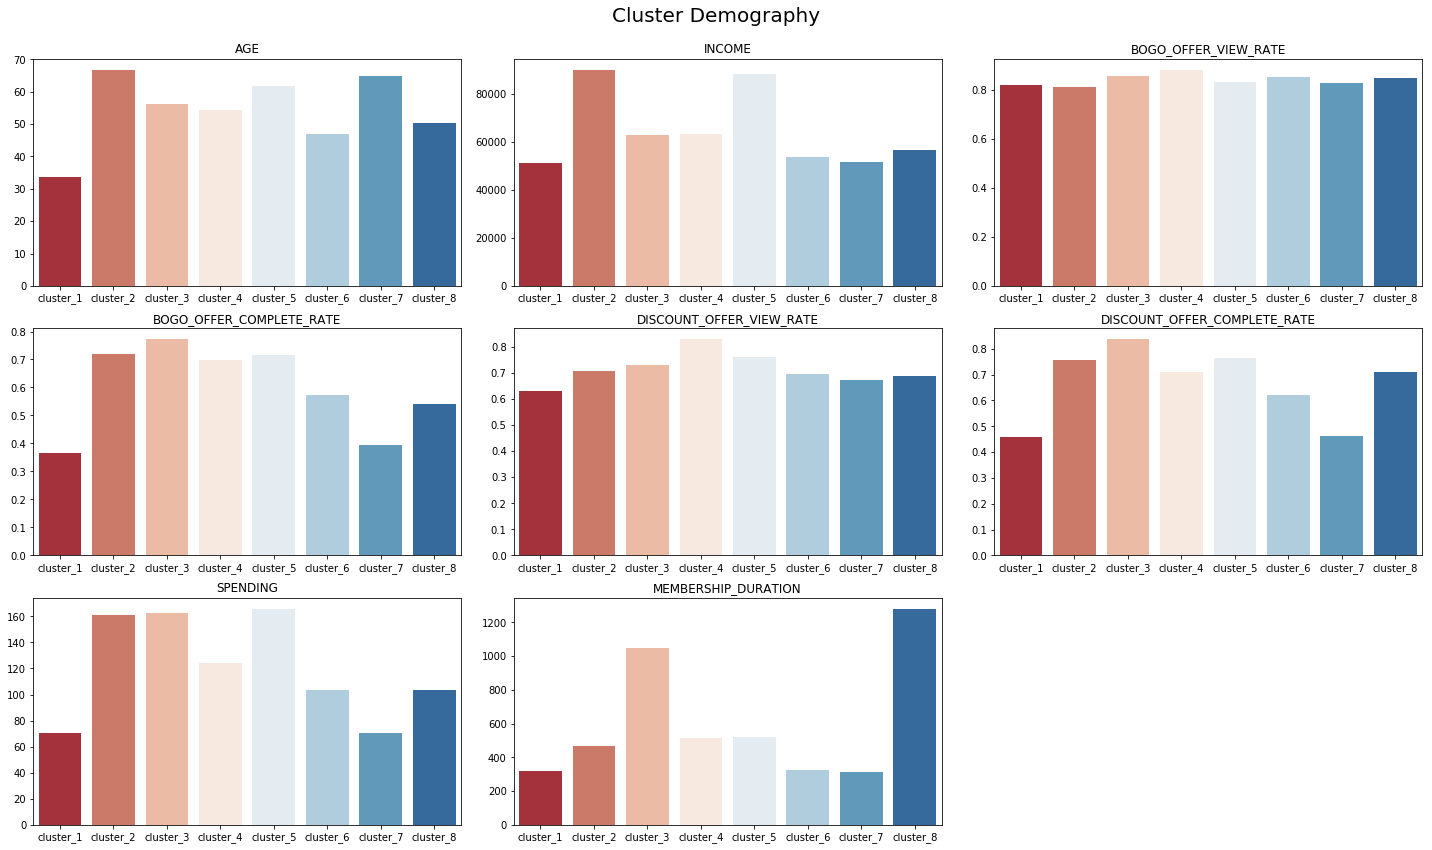

In [78]:
# Visualize various metrics among clusters
x_labels = ['cluster_{}'.format(n+1) for n in range(n_clusters)]
numerical_col_to_plot = [col for col in df_Q2.columns if df_Q2[col].dtype in [np.float64, np.int64]]
categorical_col_to_plot = [col for col in df_Q2.columns if df_Q2[col].dtype == object]

# Plot numerical features
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Cluster Demography', fontsize=20)

n_fig_col = 3
n_fig_row = len(numerical_col_to_plot) // n_fig_col + 1
for n, col in enumerate(numerical_col_to_plot) :
    ax = fig.add_subplot(n_fig_row,n_fig_col, n+1)
    #plt.subplots(figsize=(10, 6))
    vals = []
    for i in range(n_clusters):
        vals.append(clusters[i][col].mean())
    sns.barplot(x_labels,vals, palette="RdBu", ax=ax)
    # "muted"
    # "rocket"
    # "RdBu"
    ax.set_title(col.upper())

plt.tight_layout()
fig.subplots_adjust(top=0.92)

In [79]:
# Check for gender split
for i, cluster in enumerate(clusters):
    print('cluster', i+1)
    print(cluster.gender.value_counts())

cluster 1
M    2482
Name: gender, dtype: int64
cluster 2
F    2618
Name: gender, dtype: int64
cluster 3
F    1348
Name: gender, dtype: int64
cluster 4
O    212
Name: gender, dtype: int64
cluster 5
M    1993
Name: gender, dtype: int64
cluster 6
F    2163
Name: gender, dtype: int64
cluster 7
M    2296
Name: gender, dtype: int64
cluster 8
M    1713
Name: gender, dtype: int64


It seems that K-Mean splits each cluster with a specific gender.

In [146]:
# Easy to read format
for i, cluster in enumerate(clusters):
    print('cluster {}: {}'.format(i+1, clusters[i].gender.mode().values[0]))

cluster 1: M
cluster 2: F
cluster 3: F
cluster 4: O
cluster 5: M
cluster 6: F
cluster 7: M
cluster 8: M


##### Obervations
* Cluster 2, 3, and 5 have highest offer completion rates and spending
* On the other hand, cluster 1 and 7 have lowest completion rates and spending.

##### Cluster Composition
Let's check the compostions of these clusters and summarize their characteristics

In [156]:
# Ages
# Incomes
# Membership Duration
# Gender
def getRepresentativeMetrics(cluster_df):
    """Get Representative Metrics for cluster
    
    Args:
        cluster_df: cluster dataframe
    
    Returns:
        avg_age: average age
        avg_income: average income
        avg_member_duration: average membership duration in years
        gender: gender of the cluster
    
    """
    avg_age = np.round(cluster_df.age.mean(), 1)
    avg_income = np.round(cluster_df.income.mean(), 2)
    avg_member_duration = np.round(cluster_df.membership_duration.mean() / 365, 1)
    gender =  cluster_df.gender.mode().values[0]
    
    return avg_age, avg_income, avg_member_duration, gender

for ith_cluster in [2,3,5,1,7]:
    cluster_df = clusters[ith_cluster-1]
    avg_age, avg_income, avg_member_duration, gender = getRepresentativeMetrics(cluster_df)
    print('##### Cluster{} #####'.format(ith_cluster))
    print('Average age: ', avg_age, 'years old')
    print('Average income: ', avg_income, 'dollars')
    print('Average membership Duration: ', avg_member_duration, 'years')
    print('Gender: ', gender)
    print()

##### Cluster2 #####
Average age:  66.9 years old
Average income:  90258.59 dollars
Average membership Duration:  1.3 years
Gender:  F

##### Cluster3 #####
Average age:  56.2 years old
Average income:  62880.56 dollars
Average membership Duration:  2.9 years
Gender:  F

##### Cluster5 #####
Average age:  61.7 years old
Average income:  88345.21 dollars
Average membership Duration:  1.4 years
Gender:  M

##### Cluster1 #####
Average age:  33.8 years old
Average income:  51300.16 dollars
Average membership Duration:  0.9 years
Gender:  M

##### Cluster7 #####
Average age:  65.0 years old
Average income:  51686.41 dollars
Average membership Duration:  0.9 years
Gender:  M



###### Clusters with Highest Values
* `Cluster2`: consists of females with both the highest average age and income
* `Cluster3`: consists of females with second highest average age and income
* `Cluster5`: consists of males with the highest average income  

###### Clusters with Lowest Values
* `Cluster1`: consists of males with the lowest income and youngest
* `Cluster7`: consists of males with the second lowest income and oldest

## Conclusion
If the simulated app data is somewhat reflect the real behaviors of Starbucks customers, the following observations may be useful when choosing target customers to perform promotion.
* Women are more likely to respond to promotion(both BOGO and discount offers). 
* People with higher income are also more engaged in promotional offers.